In [ ]:
from pathlib import Path
root = Path().resolve()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from data import load_prices, to_returns
from metrics import sharpe_ratio, var, cvar
from portfolio import estimate_mu_cov, portfolio_perf
from optimise import global_min_variance, max_sharpe, efficient_frontier
from plots import plot_frontier, plot_points
from simulate import simulate_portfolio_paths, mc_var_cvar

## Parameters

In [15]:
TICKERS = ["AAPL", "MSFT", "SPY"]
START = "2016-01-01"
END   = "2025-01-01"
RF_ANNUAL = 0.02
PERIODS_PER_YEAR = 252
SEED = 123

## Prices and returns

In [16]:
panels = load_prices(TICKERS, START, END, fields=("Adj Close", "Volume"))
prices = panels["Adj Close"]
returns_log = to_returns(prices, method="log")
returns_simple = np.expm1(returns_log)

prices.tail()

Ticker,AAPL,MSFT,SPY
Date,,,
2024-12-24,257.286682,436.929108,596.076965
2024-12-26,258.103729,435.715790,596.116638
2024-12-27,254.685867,428.177216,589.841614
2024-12-30,251.307877,422.508362,583.110596
2024-12-31,249.534180,419.196564,580.989136


## Historical metrics: Sharpe, VaR, CVaR

In [17]:
sharpe = sharpe_ratio(returns_log, rf=0.0, periods_per_year=PERIODS_PER_YEAR, returns_are_log=True).rename("Sharpe")
var05  = var(returns_log, level=0.05, returns_are_log=True).rename("VaR 5% (one-period)")
cvar05 = cvar(returns_log, level=0.05, returns_are_log=True).rename("CVaR 5% (one-period)")

metrics_table = pd.concat([sharpe, var05, cvar05], axis=1)
metrics_table


,Sharpe,VaR 5% (one-period),CVaR 5% (one-period)
Ticker,,,
AAPL,0.913891,-0.026912,-0.041095
MSFT,0.892307,-0.026619,-0.038722
SPY,0.761278,-0.017002,-0.027574


## Estimate annualized μ and Σ

In [8]:
mu, Sigma = estimate_mu_cov(returns_log, periods_per_year=PERIODS_PER_YEAR, returns_are_log=True)
mu.to_frame("mu").join(Sigma, how="left").head()

,mu,AAPL,MSFT,SPY
Ticker,,,,
AAPL,0.261790,0.082057,0.054388,0.038788
MSFT,0.241155,0.054388,0.073041,0.039152
SPY,0.136278,0.038788,0.039152,0.032045


## Optimisation: GMV, Max Sharpe, Efficient Frontier

In [9]:
w_gmv = global_min_variance(Sigma)
w_tan = max_sharpe(mu, Sigma, rf=RF_ANNUAL)
frontier = efficient_frontier(mu, Sigma, n_points=60)

def coords(w):
    r, v, _ = portfolio_perf(w.values, mu, Sigma, rf=RF_ANNUAL)
    return v, r

gmv_pt = coords(w_gmv)
tan_pt = coords(w_tan)

gmv_pt, tan_pt

((0.17901180305606354, 0.13627777065640878),
 (0.2574456847080067, 0.2520877278466917))

## Visualisation: Efficient Frontier with GMV and Max Sharpe

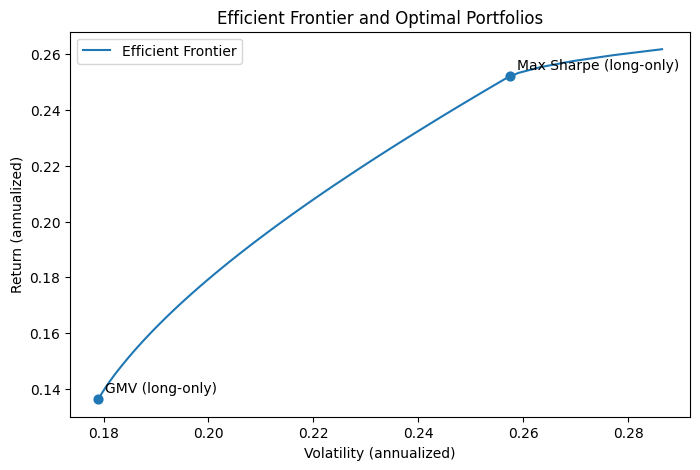

In [10]:
fig, ax = plt.subplots(figsize=(8,5))
plot_frontier(frontier, ax=ax, label="Efficient Frontier")
plot_points([gmv_pt, tan_pt], labels=["GMV (long-only)", "Max Sharpe (long-only)"], ax=ax)
ax.set_title("Efficient Frontier and Optimal Portfolios")
plt.show()

## Monte Carlo (Gaussian) — wealth paths & horizon VaR/CVaR

In [ ]:
WEALTH = simulate_portfolio_paths(
    w_tan, mu, Sigma,
    n_steps=PERIODS_PER_YEAR, n_paths=20000,
    periods_per_year=PERIODS_PER_YEAR, initial_wealth=1.0, seed=SEED
)

VaR_h, CVaR_h = mc_var_cvar(WEALTH, level=0.05)
VaR_h, CVaR_h

(-0.18721724151470392, -0.2682544237344846)

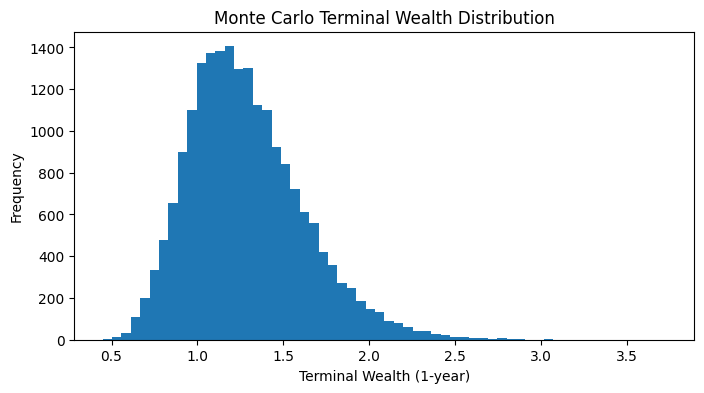

In [ ]:
terminal = WEALTH[-1, :]
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(terminal, bins=60)
ax.set_xlabel("Terminal Wealth (1-year)")
ax.set_ylabel("Frequency")
ax.set_title("Monte Carlo Terminal Wealth Distribution")
plt.show()